# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv('/datasets/Churn.csv')
data.info()

data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data  = data.drop(['Surname','CustomerId', 'RowNumber'], axis =1)
data_ohe = pd.get_dummies(data, drop_first=True)

features = data_ohe.drop(['Exited'], axis =1)
target = data_ohe['Exited']

data_ohe.info()

features_train, features_valid_test, target_train, target_valid_test = train_test_split (
    features, target, test_size=0.4, random_state=123
)
features_valid, features_test, target_valid, target_test = train_test_split (
    features_valid_test, target_valid_test, test_size=0.5, random_state=123
)

scaler = StandardScaler()
scaler.fit(features_train)
for i in [features_train, features_valid, features_test]:
    i = scaler.transform(i)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null float64
Balance              10000

При подготовке данных заполнили пропущенные значения столбца 'Tenure' медианными значениями, избавились от столбцов, не влияющих на обучение 'Surname','CustomerId', 'RowNumber'. Закодировали данные способом OHE и разделили их на 3 группы: обучающую(60%), валидационную(20%) и тестовую(20%).
Провели масштабирование признаков.

# 2. Исследование задачи

In [2]:
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score

print('Доля ушедших клиентов = {:.2%}'.format(((data['Exited']==1).sum())/((data['Exited']==0).sum())))

def fitting_model(method_name, features_train, target_train):
    model = method_name
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    probabilities = model.predict_proba(features_valid)
    probabilities_one = probabilities[:, 1]
    auc = roc_auc_score(target_valid, probabilities_one)
    return ('f1 =', f1.round(3), 'auc=', auc.round(3))


a = fitting_model(DecisionTreeClassifier(random_state = 123), features_train, target_train)
b = fitting_model(RandomForestClassifier(random_state = 123), features_train, target_train)
c = fitting_model(LogisticRegression(random_state = 123, solver = 'liblinear'), features_train, target_train)

print('DecisionTreeClassifier', a)
print('RandomForestClassifier', b)
print('LogisticRegression', c)

Доля ушедших клиентов = 25.58%


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


DecisionTreeClassifier ('f1 =', 0.508, 'auc=', 0.696)
RandomForestClassifier ('f1 =', 0.54, 'auc=', 0.827)
LogisticRegression ('f1 =', 0.067, 'auc=', 0.635)


При исследовании баланса классов выяснили, что они несбалансированны. Доля ушедших клиентов составляет 25.58%. 
Обучили 3 модели без учета дисбаланса классов и настроек параметров. Лучше всего метрики оказались для метода RandomForestClassifier, самые низкие же значения у LogisticRegression.

# 3. Борьба с дисбалансом

In [17]:
from sklearn.utils import shuffle 
from sklearn.model_selection import GridSearchCV

def zeros(features, target):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    return features_zeros, features_ones, target_zeros, target_ones
    
def upsample(features, target): 
    features_zeros, features_ones, target_zeros, target_ones = zeros(features, target)
    features_upsampled = pd.concat([features_zeros] + [features_ones] * 3)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * 3)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=123)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train)

def downsample(features, target):  
    features_zeros, features_ones, target_zeros, target_ones = zeros(features, target)
    features_downsampled = pd.concat([features_zeros.sample(frac=1/3, random_state=123)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=1/3, random_state=123)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=123)
        
    return features_downsampled, target_downsampled        

features_downsampled, target_downsampled = downsample(features_train, target_train)

parameters_DTC = {'max_depth':range(5,56,10), 'criterion':['gini', 'entropy'], 'min_samples_split':[2,3,4]}
parameters_RFC = {'n_estimators':range(5,56,10), 'max_depth':range(5,56,10), 'min_samples_split':[2,3,4]}

model_1 = DecisionTreeClassifier(random_state = 123)
model_2 = RandomForestClassifier(random_state = 123)

gread_search_DTC = GridSearchCV(estimator = model_1, param_grid = parameters_DTC, scoring='['f1', 'roc_auc'], refit='f1'', cv=5)
gread_search_RFC = GridSearchCV(estimator = model_2, param_grid = parameters_RFC, scoring=['f1', 'roc_auc'], refit='f1', cv=5)

DTC_up = gread_search_DTC.fit(features_upsampled, target_upsampled)
DTC_up_best = DTC_up.best_score_
DTC_up_roc_auc = DTC_up.cv_results_['mean_test_roc_auc'].mean()
DTC_down = gread_search_DTC.fit(features_downsampled, target_downsampled)
DTC_down_best = DTC_down.best_score_
DTC_down_roc_auc = DTC_down.cv_results_['mean_test_roc_auc'].mean()

RFC_up = gread_search_RFC.fit(features_upsampled, target_upsampled)
RFC_up_best = RFC_up.best_score_
RFC_up_roc_auc = RFC_up.cv_results_['mean_test_roc_auc'].mean()
RFC_up__parameters = RFC_up.best_params_
RFC_down = gread_search_RFC.fit(features_downsampled, target_downsampled)
RFC_down_best = RFC_down.best_score_
RFC_down_roc_auc = RFC_down.cv_results_['mean_test_roc_auc'].mean()
DTC_no_scale = gread_search_DTC.fit(features_train, target_train)
RFC_no_scale = gread_search_RFC.fit(features_train, target_train)

print('Наибольший f1 для различных моделей:')
best_f1 = pd.DataFrame(
    data=[[DTC_up_best, RFC_up_best], [DTC_down_best, RFC_down_best], [DTC_no_scale.best_score_, RFC_no_scale.best_score_]], 
    index=['upsampling', 'downsampling', 'without_scaling'],
    columns=['DecisionTreeClassifier', 'RandomForestClassifier']
) 
print(best_f1)
print()

print('Наибольший auc-roc для различных моделей:')
best_auc_roc = pd.DataFrame(
    data=[
        [DTC_up_roc_auc, RFC_up_roc_auc], 
        [DTC_down_roc_auc, RFC_down_roc_auc], 
        [DTC_no_scale.cv_results_['mean_test_roc_auc'].mean(), RFC_no_scale.cv_results_['mean_test_roc_auc'].mean()]
    ], 
    index=['upsampling', 'downsampling', 'without_scaling'],
    columns=['DecisionTreeClassifier', 'RandomForestClassifier']
) 
print(best_auc_roc)

Наибольший f1 для различных моделей:
                 DecisionTreeClassifier  RandomForestClassifier
upsampling                     0.900101                0.938654
downsampling                   0.707634                0.720016
without_scaling                0.530358                0.577116
Наибольший auc-roc для различных моделей:
                 DecisionTreeClassifier  RandomForestClassifier
upsampling                     0.899650                0.956197
downsampling                   0.717480                0.822611
without_scaling                0.710528                0.828993


In [18]:
print("Лучшие параметры для RandomForestClassifier при борьбе с дисбалансом с помощью upsample:")
print(RFC_up__parameters)

Лучшие параметры для RandomForestClassifier при борьбе с дисбалансом с помощью upsample:
{'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 55}


Параметры для DecisionTreeClassifier и RandomForestClassifier перебирали с помощью GridSearchCV. Логистическую регрессию не стали рассматривать из-за очень низкого f1 в предыдущем шаге. В сводных таблицах рассмотрели метрики f1 и auc-roc для каждой из моделей: с дисбалансом классов, избавившись от дисбаланса с помощью upsampling и downsampling. В среднем значения RandomForestClassifier лучше, чем у DecisionTreeClassifier, а борьба с дисбалансом с помощью upsampling показывает результаты лучше, чем downsampling и данных с дисбалансом.
Самого лучшего результата удалось добиться при использовании RandomForestClassifier на данных, где с дисбалансом боролись с помощью upsampling с параметрами max_depth = 25, min_samples_split = 2, n_estimators = 55.

# 4. Тестирование модели

In [19]:
model_best = RandomForestClassifier(max_depth= 25, n_estimators= 55, min_samples_split = 2, random_state = 123)
model_best.fit(features_upsampled, target_upsampled)

predictions_new = model_best.predict(features_valid)
f1 = f1_score(target_valid, predictions_new)
probabilities = model_best.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]
auc = roc_auc_score(target_valid, probabilities_one)
print('f1 на валидационной выборке =', f1)
print('auc_roc на валидационной выборке =', auc)
print()

predictions_test = model_best.predict(features_test)
f1 = f1_score(target_test, predictions_test)
probabilities = model_best.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
auc = roc_auc_score(target_test, probabilities_one)
print('f1 на тестовой выборке =', f1)
print('auc_roc на тестовой выборке =', auc)

f1 на валидационной выборке = 0.6170798898071626
auc_roc на валидационной выборке = 0.8597178410908332

f1 на тестовой выборке = 0.6208791208791209
auc_roc на тестовой выборке = 0.8488082830839474


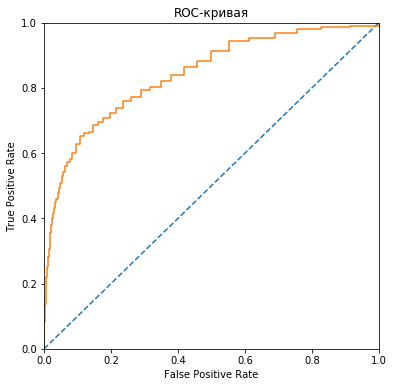

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one)
plt.figure(figsize=(6,6))
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.step(fpr, tpr, where='post')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Обучили модель с помощью параметров, подобранных в предудущем шаге. Вычислили метрики F1 и AUC-ROC как на валидационной, так и на тестовой выборках. Построили ROC-кривую для тестовой выборки.